In [1]:
import trainer.glue_base as glue_base
import models.sparse_token as sparse
import pickle, importlib
import torch
from matplotlib import pyplot as plt
importlib.reload(glue_base)
importlib.reload(sparse)
sparse.set_update_input_mask_accumulate_indices(True)

Glue = glue_base.GlueAttentionApproxTrainer

In [2]:
trainer = Glue('mrpc', 16, batch_size=1, wiki_train=False)

Trainer: mrpc


100%|██████████| 2/2 [00:00<00:00, 26.14ba/s]

Trainer: Checkpoint path saves/glue-mrpc-16.pth


In [3]:
data_iter = iter(trainer.test_dataloader)

In [4]:
batch = next(data_iter)
batch = {k: v.to(trainer.device) for k, v in batch.items()}
labels = batch['labels']
del batch['labels']

In [5]:
importlib.reload(glue_base)
importlib.reload(sparse)
sparse.set_update_input_mask_accumulate_indices(True)
def create_model(trainer, ks):
    wrapped_bert = sparse.ApproxSparseBertModel(
        trainer.model_bert, 
        approx_bert=trainer.approx_bert, 
        ks=ks)
    wrapped_bert.use_forward_sparse = False
    sparse_cls_bert = glue_base.berts.BertForSequenceClassification(trainer.model_bert.config)
    sparse_cls_bert.load_state_dict(trainer.model.state_dict())
    sparse_cls_bert.bert = wrapped_bert
    sparse_cls_bert.to(trainer.device).eval()

    return sparse_cls_bert

model = create_model(trainer, 0.1)

In [6]:
def plot_grid(tensor): plt.imshow(tensor.cpu().detach().numpy())
plt.rcParams["figure.figsize"] = (14,4)
TOKEN_LEN = torch.sum(batch['attention_mask'][0]).item() + 5

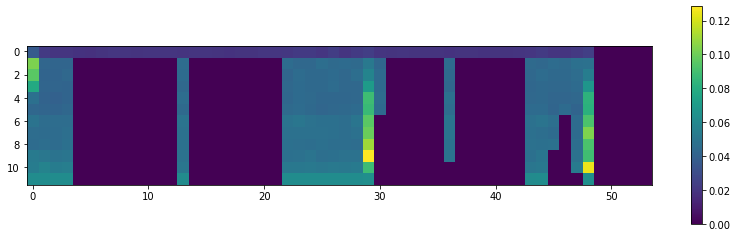

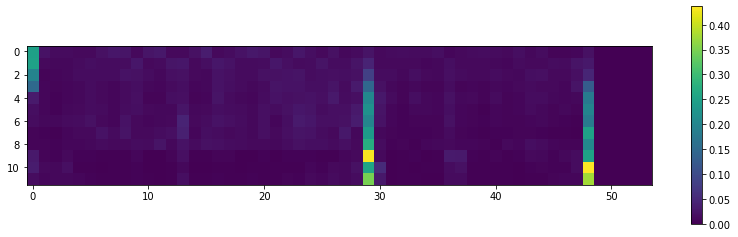

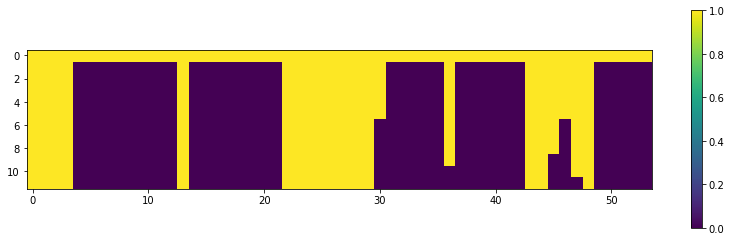

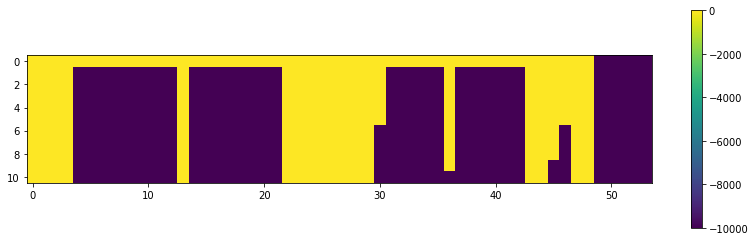

(tensor([0.7176, 0.7990, 1.2183, 1.1011, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.7432, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.2437, 1.0928, 1.1536, 1.1326, 0.8876,
         0.4806, 0.8889, 0.5186, 0.2215, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.4742, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9347, 0.6029,
         0.8133, 0.1785, 0.4809, 0.1737, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        device='cuda:0'),
 tensor([ 0.8267,  0.1549, -0.2156, -0.7234, -1.3104, -0.3582, -0.0156,  0.3393,
          0.6420,  0.0986,  0.5138,  0.2057,  1.5941, -0.9830, -0.6241,  0.5809,
          0.8626, -1.2559, -0.1151, -1.8818,  0.2564, -0.0360, -0.3248, -0.7375,
          1.1127, -0.7124, -0.4161, -0.0033, -0.2881, -2.2785,  1.0957,  0.6665,
          0.1348, -0.1413,  0.3093,  0.4727, -1.2287,  0.6152,  0.5025, -0.6066,
         -0.6124,  0.2445,  0.5721, -2.3833,  0.0989, -0.4551,  1.2341,  1.3362,
 

In [7]:
batch['output_attentions'] = True
model.bert.ks = [0.15*(x/11) for x in range(12)]
model.bert.ks[0] = 0.9999
model.bert.use_forward_sparse = False
model.bert.run_original_attention = True
sparse.set_output_masking(model.bert.sparse_bert, True)
sparse.set_backup_last_inputs(model.bert.sparse_bert, True)
sparse.set_print(model.bert.sparse_bert, False)
output = model(**batch)
sparse.set_backup_last_inputs(model.bert.sparse_bert, False)
sparse.set_print(model.bert.sparse_bert, False)
attentions = [
    layer.attention.self.last_attention_probs
    for layer in model.bert.sparse_bert.encoder.layer
]
head_reduced_attentions = [torch.mean(att[0], dim=0) for att in attentions]
token_reduced_attentions = [torch.mean(att, dim=0) for att in head_reduced_attentions]
lprobs = torch.stack(token_reduced_attentions, dim=0)
lprobs = lprobs[:,:TOKEN_LEN]
plot_grid(lprobs)
plt.colorbar()
plt.show()

attentions = [
    layer.attention.self.last_approx_attention_probs
    for layer in model.bert.sparse_bert.encoder.layer
]
head_reduced_attentions = [torch.mean(att[0], dim=0) for att in attentions]
token_reduced_attentions = [torch.mean(att, dim=0) for att in head_reduced_attentions]
lprobs = torch.stack(token_reduced_attentions, dim=0)
lprobs = lprobs[:,:TOKEN_LEN]
plot_grid(lprobs)
plt.colorbar()
plt.show()

# print(torch.sum(torch.mean(head_reduced_attentions[1], dim=0)))

# plot_grid(torch.sum(lprobs, dim=1, keepdim=True))
# print(torch.sum(lprobs, dim=1, keepdim=True))
# plt.colorbar()
# plt.show()

input_masks = [
    layer.attention.self.input_mask[0]
    for layer in model.bert.sparse_bert.encoder.layer
]
input_masks = torch.stack(input_masks, dim=0)
input_masks = input_masks[:,:TOKEN_LEN]
plot_grid(input_masks)
plt.colorbar()
plt.show()

attentions = [
    layer.attention.self.last_attention_scores
    for layer in model.bert.sparse_bert.encoder.layer
]
head_reduced_attentions = [torch.mean(att[0], dim=0) for att in attentions]
token_reduced_attentions = [torch.mean(att, dim=0) for att in head_reduced_attentions]
lprobs = torch.stack(token_reduced_attentions, dim=0)
lprobs = lprobs[:-1,:TOKEN_LEN]
plot_grid(lprobs)
plt.colorbar()
plt.show()

lq = model.bert.sparse_bert.encoder.layer[0].attention.self.last_query
lk = model.bert.sparse_bert.encoder.layer[0].attention.self.last_key

model.bert.sparse_bert.encoder.layer[0].attention.self.last_query[0,0,:TOKEN_LEN,0],\
model.bert.sparse_bert.encoder.layer[0].attention.self.last_key[0][0,1]

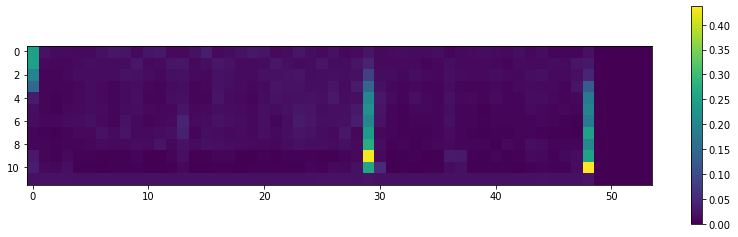

In [8]:
batch['output_attentions'] = True
model.bert.ks = [0.9999 for _ in range(12)]
model.bert.use_forward_sparse = False
output = model(**batch)
head_reduced_attentions = [torch.mean(att[0], dim=0) for att in output.attentions]
token_reduced_attentions = [torch.mean(att, dim=0) for att in head_reduced_attentions]
lprobs = torch.stack(token_reduced_attentions, dim=0)
lprobs = lprobs[:,:TOKEN_LEN]
plot_grid(lprobs)
plt.colorbar()

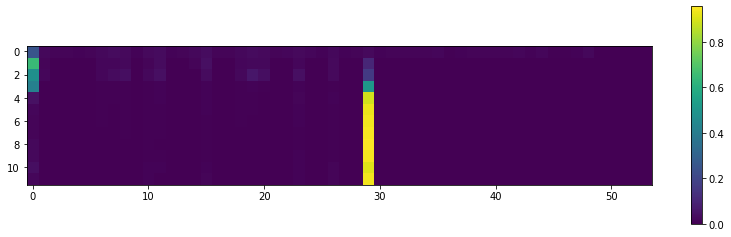

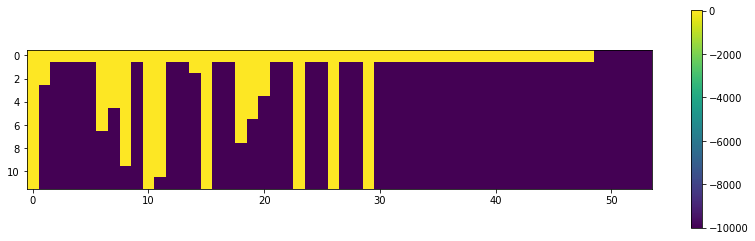

(tensor([ 0.7176,  0.7990,  1.2183,  1.1011,  0.1575,  0.1614,  0.1766,  0.7791,
          0.3523,  1.0252,  1.3391,  0.8296,  1.0164,  0.7432,  0.5464,  1.4789,
          1.0512,  0.9598,  0.3206,  1.3642,  0.3494,  0.9857,  1.2437,  1.0928,
          1.1536,  1.1326,  0.8876,  0.4806,  0.8889,  0.5186,  0.2215, -0.0961,
          0.3898, -0.1045,  0.8652,  0.4584,  0.4742,  0.2094,  0.0578,  1.1016,
          0.0305,  0.0755,  1.0107,  0.9347,  0.6029,  0.8133,  0.1785,  0.4809,
          0.1737,  0.4557,  0.4847,  0.5119,  0.3969,  0.4312], device='cuda:0'),
 tensor([ 0.8267,  0.1549, -0.2156, -0.7234, -1.3104, -0.3582, -0.0156,  0.3393,
          0.6420,  0.0986,  0.5138,  0.2057,  1.5941, -0.9830, -0.6241,  0.5809,
          0.8626, -1.2559, -0.1151, -1.8818,  0.2564, -0.0360, -0.3248, -0.7375,
          1.1127, -0.7124, -0.4161, -0.0033, -0.2881, -2.2785,  1.0957,  0.6665,
          0.1348, -0.1413,  0.3093,  0.4727, -1.2287,  0.6152,  0.5025, -0.6066,
         -0.6124,  0.2445, 

In [14]:
batch['output_attentions'] = True
#model.bert.ks = [0.1 for _ in range(12)]
target_ks = 0.1
ks = [target_ks*0.5+(1-x/11.0) * target_ks for x in range(12)]
model.bert.ks = ks
model.bert.use_forward_sparse = True
output = model(**batch)
head_reduced_attentions = [torch.mean(att[0], dim=0) for att in output.attentions]
token_reduced_attentions = [torch.mean(att, dim=0) for att in head_reduced_attentions]
lprobs = torch.stack(token_reduced_attentions, dim=0)
lprobs = lprobs[:,:TOKEN_LEN]
plot_grid(lprobs)
plt.colorbar()
plt.show()

# input_masks = [
#     layer.attention.self.input_mask[0]
#     for layer in model.bert.sparse_bert.encoder.layer
# ]
# input_masks = torch.stack(input_masks, dim=0)
# input_masks = input_masks[:,:TOKEN_LEN]
# plot_grid(input_masks)
# plt.colorbar()
# plt.show()

attentions = [
    layer.attention.self.last_attention_scores
    for layer in model.bert.sparse_bert.encoder.layer
]
head_reduced_attentions = [torch.mean(att[0], dim=0) for att in attentions]
token_reduced_attentions = [torch.mean(att, dim=0) for att in head_reduced_attentions]
lprobs = torch.stack(token_reduced_attentions, dim=0)
lprobs = lprobs[:,:TOKEN_LEN]
plot_grid(lprobs)
plt.colorbar()
plt.show()

lq_ = model.bert.sparse_bert.encoder.layer[0].attention.self.last_query
lk_ = model.bert.sparse_bert.encoder.layer[0].attention.self.last_key

model.bert.sparse_bert.encoder.layer[0].attention.self.last_query[0,0,:TOKEN_LEN,0],\
model.bert.sparse_bert.encoder.layer[0].attention.self.last_key[0][0,1],\
torch.mean(torch.square(lq-lq_)+torch.square(lk-lk_))

In [15]:
ks = [0.05 for _ in range(12)]
#ks = [0.07 * (x/11) + 0.05 for x in range(12)]
#ks = [0.1*(x/11) + 0.05 for x in range(12)]
#model.bert.ks[0] = 0.9999
sparse.benchmark_reset()
trainer.set_batch_size(1)
trainer.eval_sparse_model(ks=ks, run_original_attention=True)
print('mask_occupy', sparse.benchmark_get_average('mask_occupy'))

eval: 100%|██████████| 1725/1725 [00:45<00:00, 37.83it/s]


metric score {'accuracy': 0.391304347826087, 'f1': 0.16267942583732056}
avg occupy 0.5389886924669531
mask_occupy 0.10775256144821391


In [18]:
target_ks = 0.107
ksx = [target_ks*0.5+((1-x/11.0)**2) * target_ks for x in range(12)]
trainer.set_batch_size(8)
#'accuracy': 0.5692753623188406, 'f1': 0.558001189767995
trainer.eval_sparse_model(ks=ksx, use_forward=True)

eval: 100%|██████████| 216/216 [00:58<00:00,  3.67it/s]


metric score {'accuracy': 0.383768115942029, 'f1': 0.17788089713843774}
avg occupy 0.5389877772690274


{'accuracy': 0.383768115942029, 'f1': 0.17788089713843774}

In [13]:
a = torch.arange(0,6).unsqueeze(0).repeat(2,1)
b = torch.tensor([[0,2,1,2],[1,1,1,2]])
b = torch.unique(b, dim=1, return_counts=True, return_inverse=True)
#a.gather(dim=1, index=b)
b

(tensor([[0, 1, 2, 2],
         [1, 1, 1, 2]]),
 tensor([0, 2, 1, 3]),
 tensor([1, 1, 1, 1]))